## Practical 9 : Classification of images of clothing using Tensorflow (Fashion MNIST dataset)

use Google colab

credit : https://www.tensorflow.org/tutorials/keras/classification

In [3]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2022-12-14 06:37:29.047458: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 06:37:29.047559: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 06:37:29.047570: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


2.11.0


This guide uses the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen here:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Fashion MNIST is intended as a drop-in replacement for the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset—often used as the "Hello, World" of machine learning programs for computer vision. The MNIST dataset contains images of handwritten digits (0, 1, 2, etc.) in a format identical to that of the articles of clothing you'll use here.

This guide uses Fashion MNIST for variety, and because it's a slightly more challenging problem than regular MNIST. Both datasets are relatively small and are used to verify that an algorithm works as expected. They're good starting points to test and debug code.

Here, 60,000 images are used to train the network and 10,000 images to evaluate how accurately the network learned to classify images. You can access the Fashion MNIST directly from TensorFlow. Import and [load the Fashion MNIST data](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data) directly from TensorFlow:

In [4]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

Loading the dataset returns four NumPy arrays:

* The `train_images` and `train_labels` arrays are the *training set*—the data the model uses to learn.
* The model is tested against the *test set*, the `test_images`, and `test_labels` arrays.

The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255. The *labels* are an array of integers, ranging from 0 to 9. These correspond to the *class* of clothing the image represents:

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

Each image is mapped to a single label. Since the *class names* are not included with the dataset, store them here to use later when plotting the images:

In [5]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## Explore the data

Let's explore the format of the dataset before training the model. The following shows there are 60,000 images in the training set, with each image represented as 28 x 28 pixels:

In [6]:
train_images.shape

(60000, 28, 28)

Likewise, there are 60,000 labels in the training set:

In [7]:
len(train_labels)

60000

Each label is an integer between 0 and 9:

In [8]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

There are 10,000 images in the test set. Again, each image is represented as 28 x 28 pixels:

In [9]:
test_images.shape

(10000, 28, 28)

And the test set contains 10,000 images labels:

In [10]:
len(test_labels)

10000

## Preprocess the data

The data must be preprocessed before training the network. If you inspect the first image in the training set, you will see that the pixel values fall in the range of 0 to 255:

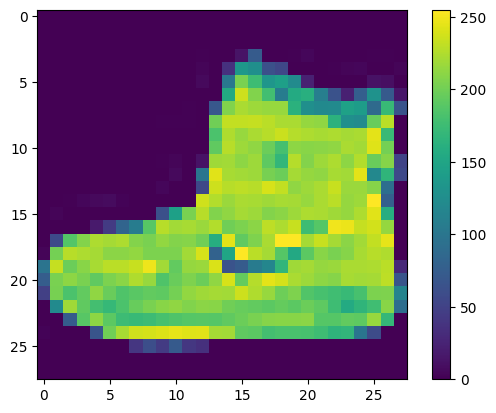

In [11]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

Scale these values to a range of 0 to 1 before feeding them to the neural network model. To do so, divide the values by 255. It's important that the *training set* and the *testing set* be preprocessed in the same way:

In [12]:
train_images = train_images / 255.0

test_images = test_images / 255.0

To verify that the data is in the correct format and that you're ready to build and train the network, let's display the first 25 images from the *training set* and display the class name below each image.

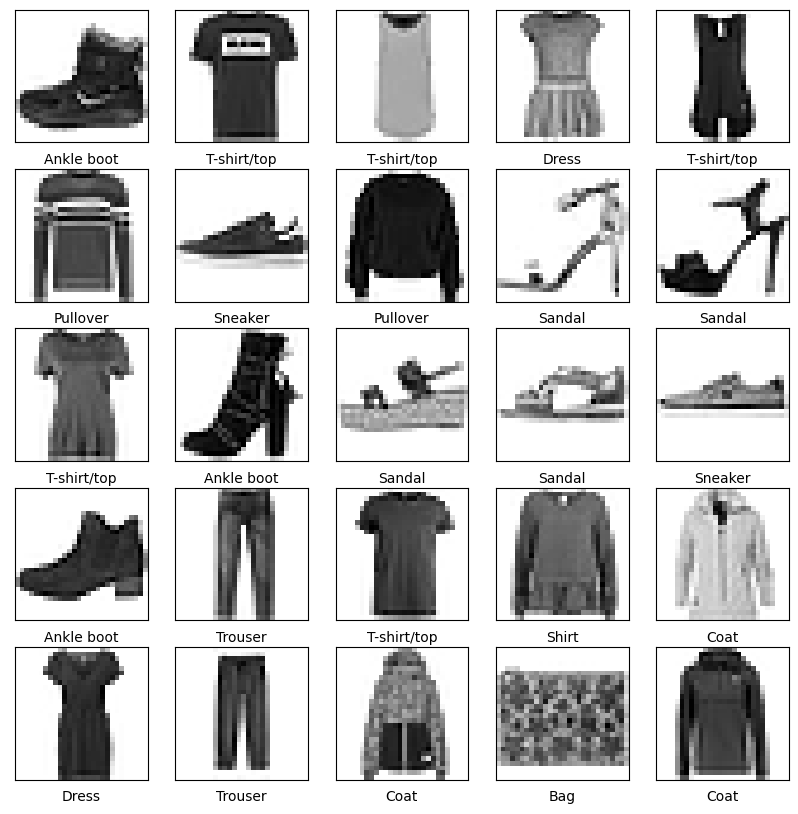

In [13]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

## Build the model

Building the neural network requires configuring the layers of the model, then compiling the model.

### Set up the layers

The basic building block of a neural network is the [*layer*](https://www.tensorflow.org/api_docs/python/tf/keras/layers). Layers extract representations from the data fed into them. Hopefully, these representations are meaningful for the problem at hand.

Most of deep learning consists of chaining together simple layers. Most layers, such as `tf.keras.layers.Dense`, have parameters that are learned during training.

In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])

The first layer in this network, `tf.keras.layers.Flatten`, transforms the format of the images from a two-dimensional array (of 28 by 28 pixels) to a one-dimensional array (of 28 * 28 = 784 pixels). Think of this layer as unstacking rows of pixels in the image and lining them up. This layer has no parameters to learn; it only reformats the data.

After the pixels are flattened, the network consists of a sequence of two `tf.keras.layers.Dense` layers. These are densely connected, or fully connected, neural layers. The first `Dense` layer has 128 nodes (or neurons). The second (and last) layer returns a logits array with length of 10. Each node contains a score that indicates the current image belongs to one of the 10 classes.

### Compile the model

Before the model is ready for training, it needs a few more settings. These are added during the model's [*compile*](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile) step:

* [*Loss function*](https://www.tensorflow.org/api_docs/python/tf/keras/losses) —This measures how accurate the model is during training. You want to minimize this function to "steer" the model in the right direction.
* [*Optimizer*](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) —This is how the model is updated based on the data it sees and its loss function.
* [*Metrics*](https://www.tensorflow.org/api_docs/python/tf/keras/metrics) —Used to monitor the training and testing steps. The following example uses *accuracy*, the fraction of the images that are correctly classified.

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Train the model

Training the neural network model requires the following steps:

1. Feed the training data to the model. In this example, the training data is in the `train_images` and `train_labels` arrays.
2. The model learns to associate images and labels.
3. You ask the model to make predictions about a test set—in this example, the `test_images` array.
4. Verify that the predictions match the labels from the `test_labels` array.


### Feed the model

To start training,  call the [`model.fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) method—so called because it "fits" the model to the training data:

In [16]:
model.fit(train_images, train_labels, epochs=10)

Epoch 1/10



   1/1875 [..............................] - ETA: 39:10 - loss: 2.2333 - accuracy: 0.1250


  24/1875 [..............................] - ETA: 4s - loss: 1.3738 - accuracy: 0.5286   


  48/1875 [..............................] - ETA: 3s - loss: 1.1290 - accuracy: 0.6042


  73/1875 [>.............................] - ETA: 3s - loss: 1.0034 - accuracy: 0.6511


  98/1875 [>.............................] - ETA: 3s - loss: 0.9214 - accuracy: 0.6824


 123/1875 [>.............................] - ETA: 3s - loss: 0.8622 - accuracy: 0.7045


 148/1875 [=>............................] - ETA: 3s - loss: 0.8246 - accuracy: 0.7194


 173/1875 [=>............................] - ETA: 3s - loss: 0.7939 - accuracy: 0.7274


 198/1875 [==>...........................] - ETA: 3s - loss: 0.7744 - accuracy: 0.7322


 223/1875 [==>...........................] - ETA: 3s - loss: 0.7577 - accuracy: 0.7382


 248/1875 [==>...........................] - ETA: 3s - loss: 0.7352 - accuracy: 0.7457


 273/1875 [===>..........................] - ETA: 3s - loss: 0.7183 - accuracy: 0.7515


 298/1875 [===>..........................] - ETA: 3s - loss: 0.7025 - accuracy: 0.7566


 322/1875 [====>.........................] - ETA: 3s - loss: 0.6903 - accuracy: 0.7602


 347/1875 [====>.........................] - ETA: 3s - loss: 0.6788 - accuracy: 0.7635


 372/1875 [====>.........................] - ETA: 3s - loss: 0.6650 - accuracy: 0.7685


 398/1875 [=====>........................] - ETA: 3s - loss: 0.6563 - accuracy: 0.7714


 424/1875 [=====>........................] - ETA: 2s - loss: 0.6500 - accuracy: 0.7738


 450/1875 [======>.......................] - ETA: 2s - loss: 0.6392 - accuracy: 0.7771


 475/1875 [======>.......................] - ETA: 2s - loss: 0.6289 - accuracy: 0.7809


 501/1875 [=======>......................] - ETA: 2s - loss: 0.6215 - accuracy: 0.7841


 527/1875 [=======>......................] - ETA: 2s - loss: 0.6179 - accuracy: 0.7852


 553/1875 [=======>......................] - ETA: 2s - loss: 0.6126 - accuracy: 0.7870


 579/1875 [========>.....................] - ETA: 2s - loss: 0.6071 - accuracy: 0.7889


 605/1875 [========>.....................] - ETA: 2s - loss: 0.6057 - accuracy: 0.7890


 631/1875 [=========>....................] - ETA: 2s - loss: 0.6011 - accuracy: 0.7906


 657/1875 [=========>....................] - ETA: 2s - loss: 0.5944 - accuracy: 0.7933


 683/1875 [=========>....................] - ETA: 2s - loss: 0.5930 - accuracy: 0.7943


 709/1875 [==========>...................] - ETA: 2s - loss: 0.5903 - accuracy: 0.7950


 735/1875 [==========>...................] - ETA: 2s - loss: 0.5855 - accuracy: 0.7965


 761/1875 [===========>..................] - ETA: 2s - loss: 0.5840 - accuracy: 0.7969


 787/1875 [===========>..................] - ETA: 2s - loss: 0.5809 - accuracy: 0.7978


 814/1875 [============>.................] - ETA: 2s - loss: 0.5772 - accuracy: 0.7990


 840/1875 [============>.................] - ETA: 2s - loss: 0.5725 - accuracy: 0.8008


 865/1875 [============>.................] - ETA: 2s - loss: 0.5679 - accuracy: 0.8022


 891/1875 [=============>................] - ETA: 1s - loss: 0.5640 - accuracy: 0.8031


 916/1875 [=============>................] - ETA: 1s - loss: 0.5612 - accuracy: 0.8039


 942/1875 [==============>...............] - ETA: 1s - loss: 0.5596 - accuracy: 0.8041


 968/1875 [==============>...............] - ETA: 1s - loss: 0.5583 - accuracy: 0.8042


 994/1875 [==============>...............] - ETA: 1s - loss: 0.5555 - accuracy: 0.8050


1020/1875 [===============>..............] - ETA: 1s - loss: 0.5535 - accuracy: 0.8059


1046/1875 [===============>..............] - ETA: 1s - loss: 0.5526 - accuracy: 0.8064


1072/1875 [================>.............] - ETA: 1s - loss: 0.5497 - accuracy: 0.8073


1098/1875 [================>.............] - ETA: 1s - loss: 0.5467 - accuracy: 0.8077


1124/1875 [================>.............] - ETA: 1s - loss: 0.5458 - accuracy: 0.8079


1150/1875 [=================>............] - ETA: 1s - loss: 0.5435 - accuracy: 0.8089


1176/1875 [=================>............] - ETA: 1s - loss: 0.5419 - accuracy: 0.8096


1203/1875 [==================>...........] - ETA: 1s - loss: 0.5396 - accuracy: 0.8103


1229/1875 [==================>...........] - ETA: 1s - loss: 0.5376 - accuracy: 0.8109


1255/1875 [===================>..........] - ETA: 1s - loss: 0.5351 - accuracy: 0.8118


1281/1875 [===================>..........] - ETA: 1s - loss: 0.5328 - accuracy: 0.8124


1306/1875 [===================>..........] - ETA: 1s - loss: 0.5309 - accuracy: 0.8131


1330/1875 [====================>.........] - ETA: 1s - loss: 0.5281 - accuracy: 0.8138


1353/1875 [====================>.........] - ETA: 1s - loss: 0.5262 - accuracy: 0.8144


1377/1875 [=====================>........] - ETA: 0s - loss: 0.5254 - accuracy: 0.8149


1402/1875 [=====================>........] - ETA: 0s - loss: 0.5226 - accuracy: 0.8159


1427/1875 [=====================>........] - ETA: 0s - loss: 0.5207 - accuracy: 0.8162


1452/1875 [======================>.......] - ETA: 0s - loss: 0.5191 - accuracy: 0.8167


1478/1875 [======================>.......] - ETA: 0s - loss: 0.5175 - accuracy: 0.8173


1504/1875 [=======================>......] - ETA: 0s - loss: 0.5159 - accuracy: 0.8180


1530/1875 [=======================>......] - ETA: 0s - loss: 0.5143 - accuracy: 0.8186


1555/1875 [=======================>......] - ETA: 0s - loss: 0.5134 - accuracy: 0.8188


1580/1875 [========================>.....] - ETA: 0s - loss: 0.5116 - accuracy: 0.8194


1606/1875 [========================>.....] - ETA: 0s - loss: 0.5104 - accuracy: 0.8197


1631/1875 [=========================>....] - ETA: 0s - loss: 0.5092 - accuracy: 0.8199


1656/1875 [=========================>....] - ETA: 0s - loss: 0.5083 - accuracy: 0.8202


1681/1875 [=========================>....] - ETA: 0s - loss: 0.5065 - accuracy: 0.8209


1706/1875 [==========================>...] - ETA: 0s - loss: 0.5048 - accuracy: 0.8216


1732/1875 [==========================>...] - ETA: 0s - loss: 0.5030 - accuracy: 0.8222


1759/1875 [===========================>..] - ETA: 0s - loss: 0.5012 - accuracy: 0.8230


1785/1875 [===========================>..] - ETA: 0s - loss: 0.5001 - accuracy: 0.8234


1811/1875 [===========================>..] - ETA: 0s - loss: 0.4989 - accuracy: 0.8236


1836/1875 [============================>.] - ETA: 0s - loss: 0.4979 - accuracy: 0.8240


1862/1875 [============================>.] - ETA: 0s - loss: 0.4966 - accuracy: 0.8245


1875/1875 [==============================] - 5s 2ms/step - loss: 0.4960 - accuracy: 0.8246


Epoch 2/10



   1/1875 [..............................] - ETA: 4s - loss: 0.4154 - accuracy: 0.8125


  27/1875 [..............................] - ETA: 3s - loss: 0.3980 - accuracy: 0.8553


  53/1875 [..............................] - ETA: 3s - loss: 0.3986 - accuracy: 0.8561


  78/1875 [>.............................] - ETA: 3s - loss: 0.3936 - accuracy: 0.8586


 104/1875 [>.............................] - ETA: 3s - loss: 0.3838 - accuracy: 0.8612


 130/1875 [=>............................] - ETA: 3s - loss: 0.3901 - accuracy: 0.8579


 157/1875 [=>............................] - ETA: 3s - loss: 0.3839 - accuracy: 0.8607


 182/1875 [=>............................] - ETA: 3s - loss: 0.3776 - accuracy: 0.8625


 207/1875 [==>...........................] - ETA: 3s - loss: 0.3760 - accuracy: 0.8617


 232/1875 [==>...........................] - ETA: 3s - loss: 0.3791 - accuracy: 0.8607


 257/1875 [===>..........................] - ETA: 3s - loss: 0.3805 - accuracy: 0.8610


 281/1875 [===>..........................] - ETA: 3s - loss: 0.3838 - accuracy: 0.8601


 306/1875 [===>..........................] - ETA: 3s - loss: 0.3860 - accuracy: 0.8602


 331/1875 [====>.........................] - ETA: 3s - loss: 0.3878 - accuracy: 0.8601


 356/1875 [====>.........................] - ETA: 3s - loss: 0.3874 - accuracy: 0.8605


 382/1875 [=====>........................] - ETA: 2s - loss: 0.3874 - accuracy: 0.8605


 408/1875 [=====>........................] - ETA: 2s - loss: 0.3878 - accuracy: 0.8601


 434/1875 [=====>........................] - ETA: 2s - loss: 0.3851 - accuracy: 0.8614


 460/1875 [======>.......................] - ETA: 2s - loss: 0.3858 - accuracy: 0.8615


 485/1875 [======>.......................] - ETA: 2s - loss: 0.3858 - accuracy: 0.8613


 511/1875 [=======>......................] - ETA: 2s - loss: 0.3848 - accuracy: 0.8620


 537/1875 [=======>......................] - ETA: 2s - loss: 0.3836 - accuracy: 0.8617


 563/1875 [========>.....................] - ETA: 2s - loss: 0.3833 - accuracy: 0.8621


 588/1875 [========>.....................] - ETA: 2s - loss: 0.3812 - accuracy: 0.8630


 614/1875 [========>.....................] - ETA: 2s - loss: 0.3809 - accuracy: 0.8635


 639/1875 [=========>....................] - ETA: 2s - loss: 0.3799 - accuracy: 0.8636


 665/1875 [=========>....................] - ETA: 2s - loss: 0.3801 - accuracy: 0.8634


 691/1875 [==========>...................] - ETA: 2s - loss: 0.3805 - accuracy: 0.8636


 717/1875 [==========>...................] - ETA: 2s - loss: 0.3807 - accuracy: 0.8632


 742/1875 [==========>...................] - ETA: 2s - loss: 0.3808 - accuracy: 0.8632


 768/1875 [===========>..................] - ETA: 2s - loss: 0.3788 - accuracy: 0.8641


 793/1875 [===========>..................] - ETA: 2s - loss: 0.3813 - accuracy: 0.8630


 819/1875 [============>.................] - ETA: 2s - loss: 0.3806 - accuracy: 0.8634


 845/1875 [============>.................] - ETA: 2s - loss: 0.3798 - accuracy: 0.8638


 871/1875 [============>.................] - ETA: 2s - loss: 0.3806 - accuracy: 0.8633


 896/1875 [=============>................] - ETA: 1s - loss: 0.3803 - accuracy: 0.8635


 921/1875 [=============>................] - ETA: 1s - loss: 0.3799 - accuracy: 0.8641


 946/1875 [==============>...............] - ETA: 1s - loss: 0.3796 - accuracy: 0.8640


 971/1875 [==============>...............] - ETA: 1s - loss: 0.3796 - accuracy: 0.8642


 996/1875 [==============>...............] - ETA: 1s - loss: 0.3796 - accuracy: 0.8644


1022/1875 [===============>..............] - ETA: 1s - loss: 0.3790 - accuracy: 0.8645


1047/1875 [===============>..............] - ETA: 1s - loss: 0.3784 - accuracy: 0.8650


1073/1875 [================>.............] - ETA: 1s - loss: 0.3787 - accuracy: 0.8648


1098/1875 [================>.............] - ETA: 1s - loss: 0.3788 - accuracy: 0.8652


1124/1875 [================>.............] - ETA: 1s - loss: 0.3788 - accuracy: 0.8651


1149/1875 [=================>............] - ETA: 1s - loss: 0.3790 - accuracy: 0.8651


1174/1875 [=================>............] - ETA: 1s - loss: 0.3776 - accuracy: 0.8657


1199/1875 [==================>...........] - ETA: 1s - loss: 0.3773 - accuracy: 0.8658


1225/1875 [==================>...........] - ETA: 1s - loss: 0.3768 - accuracy: 0.8657


1252/1875 [===================>..........] - ETA: 1s - loss: 0.3763 - accuracy: 0.8660


1277/1875 [===================>..........] - ETA: 1s - loss: 0.3775 - accuracy: 0.8654


1302/1875 [===================>..........] - ETA: 1s - loss: 0.3770 - accuracy: 0.8655


1327/1875 [====================>.........] - ETA: 1s - loss: 0.3767 - accuracy: 0.8656


1353/1875 [====================>.........] - ETA: 1s - loss: 0.3765 - accuracy: 0.8656


1379/1875 [=====================>........] - ETA: 0s - loss: 0.3754 - accuracy: 0.8657


1406/1875 [=====================>........] - ETA: 0s - loss: 0.3755 - accuracy: 0.8656


1432/1875 [=====================>........] - ETA: 0s - loss: 0.3757 - accuracy: 0.8657


1457/1875 [======================>.......] - ETA: 0s - loss: 0.3755 - accuracy: 0.8657


1482/1875 [======================>.......] - ETA: 0s - loss: 0.3746 - accuracy: 0.8660


1507/1875 [=======================>......] - ETA: 0s - loss: 0.3747 - accuracy: 0.8661


1533/1875 [=======================>......] - ETA: 0s - loss: 0.3748 - accuracy: 0.8658


1558/1875 [=======================>......] - ETA: 0s - loss: 0.3745 - accuracy: 0.8658


1583/1875 [========================>.....] - ETA: 0s - loss: 0.3741 - accuracy: 0.8661


1609/1875 [========================>.....] - ETA: 0s - loss: 0.3746 - accuracy: 0.8662


1633/1875 [=========================>....] - ETA: 0s - loss: 0.3740 - accuracy: 0.8664


1658/1875 [=========================>....] - ETA: 0s - loss: 0.3735 - accuracy: 0.8665


1682/1875 [=========================>....] - ETA: 0s - loss: 0.3736 - accuracy: 0.8664


1707/1875 [==========================>...] - ETA: 0s - loss: 0.3738 - accuracy: 0.8663


1732/1875 [==========================>...] - ETA: 0s - loss: 0.3734 - accuracy: 0.8664


1757/1875 [===========================>..] - ETA: 0s - loss: 0.3729 - accuracy: 0.8664


1781/1875 [===========================>..] - ETA: 0s - loss: 0.3727 - accuracy: 0.8663


1806/1875 [===========================>..] - ETA: 0s - loss: 0.3730 - accuracy: 0.8663


1832/1875 [============================>.] - ETA: 0s - loss: 0.3729 - accuracy: 0.8662


1857/1875 [============================>.] - ETA: 0s - loss: 0.3725 - accuracy: 0.8662


1875/1875 [==============================] - 4s 2ms/step - loss: 0.3721 - accuracy: 0.8663


Epoch 3/10



   1/1875 [..............................] - ETA: 4s - loss: 0.4014 - accuracy: 0.8750


  26/1875 [..............................] - ETA: 3s - loss: 0.3821 - accuracy: 0.8690


  51/1875 [..............................] - ETA: 3s - loss: 0.3550 - accuracy: 0.8756


  76/1875 [>.............................] - ETA: 3s - loss: 0.3408 - accuracy: 0.8783


 101/1875 [>.............................] - ETA: 3s - loss: 0.3387 - accuracy: 0.8809


 127/1875 [=>............................] - ETA: 3s - loss: 0.3273 - accuracy: 0.8841


 152/1875 [=>............................] - ETA: 3s - loss: 0.3266 - accuracy: 0.8847


 178/1875 [=>............................] - ETA: 3s - loss: 0.3308 - accuracy: 0.8834


 203/1875 [==>...........................] - ETA: 3s - loss: 0.3269 - accuracy: 0.8856


 229/1875 [==>...........................] - ETA: 3s - loss: 0.3277 - accuracy: 0.8856


 254/1875 [===>..........................] - ETA: 3s - loss: 0.3277 - accuracy: 0.8855


 280/1875 [===>..........................] - ETA: 3s - loss: 0.3312 - accuracy: 0.8842


 305/1875 [===>..........................] - ETA: 3s - loss: 0.3320 - accuracy: 0.8838


 331/1875 [====>.........................] - ETA: 3s - loss: 0.3321 - accuracy: 0.8832


 357/1875 [====>.........................] - ETA: 3s - loss: 0.3368 - accuracy: 0.8813


 382/1875 [=====>........................] - ETA: 2s - loss: 0.3352 - accuracy: 0.8807


 406/1875 [=====>........................] - ETA: 2s - loss: 0.3352 - accuracy: 0.8806


 431/1875 [=====>........................] - ETA: 2s - loss: 0.3354 - accuracy: 0.8802


 456/1875 [======>.......................] - ETA: 2s - loss: 0.3344 - accuracy: 0.8808


 481/1875 [======>.......................] - ETA: 2s - loss: 0.3327 - accuracy: 0.8811


 506/1875 [=======>......................] - ETA: 2s - loss: 0.3323 - accuracy: 0.8809


 531/1875 [=======>......................] - ETA: 2s - loss: 0.3358 - accuracy: 0.8794


 556/1875 [=======>......................] - ETA: 2s - loss: 0.3342 - accuracy: 0.8799


 581/1875 [========>.....................] - ETA: 2s - loss: 0.3347 - accuracy: 0.8795


 606/1875 [========>.....................] - ETA: 2s - loss: 0.3346 - accuracy: 0.8798


 631/1875 [=========>....................] - ETA: 2s - loss: 0.3346 - accuracy: 0.8800


 656/1875 [=========>....................] - ETA: 2s - loss: 0.3339 - accuracy: 0.8800


 682/1875 [=========>....................] - ETA: 2s - loss: 0.3343 - accuracy: 0.8799


 708/1875 [==========>...................] - ETA: 2s - loss: 0.3339 - accuracy: 0.8796


 734/1875 [==========>...................] - ETA: 2s - loss: 0.3348 - accuracy: 0.8792


 760/1875 [===========>..................] - ETA: 2s - loss: 0.3337 - accuracy: 0.8795


 785/1875 [===========>..................] - ETA: 2s - loss: 0.3334 - accuracy: 0.8797


 809/1875 [===========>..................] - ETA: 2s - loss: 0.3333 - accuracy: 0.8794


 833/1875 [============>.................] - ETA: 2s - loss: 0.3331 - accuracy: 0.8797


 857/1875 [============>.................] - ETA: 2s - loss: 0.3344 - accuracy: 0.8794


 881/1875 [=============>................] - ETA: 2s - loss: 0.3336 - accuracy: 0.8797


 905/1875 [=============>................] - ETA: 1s - loss: 0.3340 - accuracy: 0.8797


 929/1875 [=============>................] - ETA: 1s - loss: 0.3335 - accuracy: 0.8795


 955/1875 [==============>...............] - ETA: 1s - loss: 0.3338 - accuracy: 0.8794


 980/1875 [==============>...............] - ETA: 1s - loss: 0.3347 - accuracy: 0.8794


1005/1875 [===============>..............] - ETA: 1s - loss: 0.3360 - accuracy: 0.8790


1030/1875 [===============>..............] - ETA: 1s - loss: 0.3359 - accuracy: 0.8792


1055/1875 [===============>..............] - ETA: 1s - loss: 0.3355 - accuracy: 0.8792


1080/1875 [================>.............] - ETA: 1s - loss: 0.3373 - accuracy: 0.8785


1105/1875 [================>.............] - ETA: 1s - loss: 0.3371 - accuracy: 0.8787


1130/1875 [=================>............] - ETA: 1s - loss: 0.3366 - accuracy: 0.8788


1154/1875 [=================>............] - ETA: 1s - loss: 0.3359 - accuracy: 0.8793


1178/1875 [=================>............] - ETA: 1s - loss: 0.3353 - accuracy: 0.8794


1203/1875 [==================>...........] - ETA: 1s - loss: 0.3348 - accuracy: 0.8795


1228/1875 [==================>...........] - ETA: 1s - loss: 0.3353 - accuracy: 0.8794


1253/1875 [===================>..........] - ETA: 1s - loss: 0.3352 - accuracy: 0.8792


1278/1875 [===================>..........] - ETA: 1s - loss: 0.3351 - accuracy: 0.8790


1304/1875 [===================>..........] - ETA: 1s - loss: 0.3351 - accuracy: 0.8789


1330/1875 [====================>.........] - ETA: 1s - loss: 0.3351 - accuracy: 0.8788


1355/1875 [====================>.........] - ETA: 1s - loss: 0.3347 - accuracy: 0.8790


1380/1875 [=====================>........] - ETA: 1s - loss: 0.3349 - accuracy: 0.8790


1405/1875 [=====================>........] - ETA: 0s - loss: 0.3354 - accuracy: 0.8786


1429/1875 [=====================>........] - ETA: 0s - loss: 0.3353 - accuracy: 0.8785


1454/1875 [======================>.......] - ETA: 0s - loss: 0.3353 - accuracy: 0.8782


1479/1875 [======================>.......] - ETA: 0s - loss: 0.3349 - accuracy: 0.8782


1504/1875 [=======================>......] - ETA: 0s - loss: 0.3350 - accuracy: 0.8783


1529/1875 [=======================>......] - ETA: 0s - loss: 0.3344 - accuracy: 0.8787


1554/1875 [=======================>......] - ETA: 0s - loss: 0.3348 - accuracy: 0.8785


1579/1875 [========================>.....] - ETA: 0s - loss: 0.3344 - accuracy: 0.8786


1604/1875 [========================>.....] - ETA: 0s - loss: 0.3348 - accuracy: 0.8786


1629/1875 [=========================>....] - ETA: 0s - loss: 0.3351 - accuracy: 0.8785


1653/1875 [=========================>....] - ETA: 0s - loss: 0.3355 - accuracy: 0.8781


1677/1875 [=========================>....] - ETA: 0s - loss: 0.3349 - accuracy: 0.8781


1702/1875 [==========================>...] - ETA: 0s - loss: 0.3346 - accuracy: 0.8782


1727/1875 [==========================>...] - ETA: 0s - loss: 0.3352 - accuracy: 0.8779


1752/1875 [===========================>..] - ETA: 0s - loss: 0.3355 - accuracy: 0.8779


1777/1875 [===========================>..] - ETA: 0s - loss: 0.3352 - accuracy: 0.8778


1801/1875 [===========================>..] - ETA: 0s - loss: 0.3353 - accuracy: 0.8777


1826/1875 [============================>.] - ETA: 0s - loss: 0.3351 - accuracy: 0.8777


1851/1875 [============================>.] - ETA: 0s - loss: 0.3354 - accuracy: 0.8778


1875/1875 [==============================] - 4s 2ms/step - loss: 0.3355 - accuracy: 0.8779


Epoch 4/10



   1/1875 [..............................] - ETA: 5s - loss: 0.3989 - accuracy: 0.8438


  26/1875 [..............................] - ETA: 3s - loss: 0.2761 - accuracy: 0.9002


  51/1875 [..............................] - ETA: 3s - loss: 0.2910 - accuracy: 0.8909


  75/1875 [>.............................] - ETA: 3s - loss: 0.2950 - accuracy: 0.8917


  99/1875 [>.............................] - ETA: 3s - loss: 0.3038 - accuracy: 0.8873


 124/1875 [>.............................] - ETA: 3s - loss: 0.3051 - accuracy: 0.8884


 149/1875 [=>............................] - ETA: 3s - loss: 0.3105 - accuracy: 0.8878


 174/1875 [=>............................] - ETA: 3s - loss: 0.3093 - accuracy: 0.8851


 199/1875 [==>...........................] - ETA: 3s - loss: 0.3045 - accuracy: 0.8860


 224/1875 [==>...........................] - ETA: 3s - loss: 0.3013 - accuracy: 0.8881


 249/1875 [==>...........................] - ETA: 3s - loss: 0.3035 - accuracy: 0.8882


 274/1875 [===>..........................] - ETA: 3s - loss: 0.3042 - accuracy: 0.8874


 299/1875 [===>..........................] - ETA: 3s - loss: 0.3058 - accuracy: 0.8864


 324/1875 [====>.........................] - ETA: 3s - loss: 0.3061 - accuracy: 0.8864


 349/1875 [====>.........................] - ETA: 3s - loss: 0.3040 - accuracy: 0.8875


 374/1875 [====>.........................] - ETA: 3s - loss: 0.3071 - accuracy: 0.8871


 399/1875 [=====>........................] - ETA: 3s - loss: 0.3067 - accuracy: 0.8872


 424/1875 [=====>........................] - ETA: 2s - loss: 0.3066 - accuracy: 0.8872


 449/1875 [======>.......................] - ETA: 2s - loss: 0.3072 - accuracy: 0.8869


 474/1875 [======>.......................] - ETA: 2s - loss: 0.3101 - accuracy: 0.8856


 500/1875 [=======>......................] - ETA: 2s - loss: 0.3100 - accuracy: 0.8861


 525/1875 [=======>......................] - ETA: 2s - loss: 0.3095 - accuracy: 0.8863


 550/1875 [=======>......................] - ETA: 2s - loss: 0.3102 - accuracy: 0.8863


 575/1875 [========>.....................] - ETA: 2s - loss: 0.3099 - accuracy: 0.8867


 600/1875 [========>.....................] - ETA: 2s - loss: 0.3085 - accuracy: 0.8874


 625/1875 [=========>....................] - ETA: 2s - loss: 0.3100 - accuracy: 0.8873


 650/1875 [=========>....................] - ETA: 2s - loss: 0.3101 - accuracy: 0.8869


 676/1875 [=========>....................] - ETA: 2s - loss: 0.3109 - accuracy: 0.8864


 701/1875 [==========>...................] - ETA: 2s - loss: 0.3128 - accuracy: 0.8859


 727/1875 [==========>...................] - ETA: 2s - loss: 0.3137 - accuracy: 0.8855


 753/1875 [===========>..................] - ETA: 2s - loss: 0.3146 - accuracy: 0.8851


 778/1875 [===========>..................] - ETA: 2s - loss: 0.3139 - accuracy: 0.8857


 804/1875 [===========>..................] - ETA: 2s - loss: 0.3143 - accuracy: 0.8854


 830/1875 [============>.................] - ETA: 2s - loss: 0.3146 - accuracy: 0.8852


 856/1875 [============>.................] - ETA: 2s - loss: 0.3138 - accuracy: 0.8856


 881/1875 [=============>................] - ETA: 2s - loss: 0.3138 - accuracy: 0.8860


 906/1875 [=============>................] - ETA: 1s - loss: 0.3140 - accuracy: 0.8861


 932/1875 [=============>................] - ETA: 1s - loss: 0.3145 - accuracy: 0.8862


 958/1875 [==============>...............] - ETA: 1s - loss: 0.3135 - accuracy: 0.8866


 983/1875 [==============>...............] - ETA: 1s - loss: 0.3140 - accuracy: 0.8863


1008/1875 [===============>..............] - ETA: 1s - loss: 0.3126 - accuracy: 0.8867


1034/1875 [===============>..............] - ETA: 1s - loss: 0.3115 - accuracy: 0.8869


1060/1875 [===============>..............] - ETA: 1s - loss: 0.3135 - accuracy: 0.8863


1085/1875 [================>.............] - ETA: 1s - loss: 0.3130 - accuracy: 0.8868


1111/1875 [================>.............] - ETA: 1s - loss: 0.3128 - accuracy: 0.8866


1137/1875 [=================>............] - ETA: 1s - loss: 0.3121 - accuracy: 0.8870


1162/1875 [=================>............] - ETA: 1s - loss: 0.3115 - accuracy: 0.8872


1187/1875 [=================>............] - ETA: 1s - loss: 0.3113 - accuracy: 0.8871


1211/1875 [==================>...........] - ETA: 1s - loss: 0.3107 - accuracy: 0.8872


1235/1875 [==================>...........] - ETA: 1s - loss: 0.3111 - accuracy: 0.8869


1260/1875 [===================>..........] - ETA: 1s - loss: 0.3107 - accuracy: 0.8869


1284/1875 [===================>..........] - ETA: 1s - loss: 0.3106 - accuracy: 0.8869


1308/1875 [===================>..........] - ETA: 1s - loss: 0.3112 - accuracy: 0.8866


1333/1875 [====================>.........] - ETA: 1s - loss: 0.3111 - accuracy: 0.8868


1358/1875 [====================>.........] - ETA: 1s - loss: 0.3114 - accuracy: 0.8868


1383/1875 [=====================>........] - ETA: 0s - loss: 0.3115 - accuracy: 0.8867


1408/1875 [=====================>........] - ETA: 0s - loss: 0.3112 - accuracy: 0.8867


1433/1875 [=====================>........] - ETA: 0s - loss: 0.3116 - accuracy: 0.8866


1458/1875 [======================>.......] - ETA: 0s - loss: 0.3116 - accuracy: 0.8866


1483/1875 [======================>.......] - ETA: 0s - loss: 0.3119 - accuracy: 0.8862


1508/1875 [=======================>......] - ETA: 0s - loss: 0.3117 - accuracy: 0.8866


1534/1875 [=======================>......] - ETA: 0s - loss: 0.3111 - accuracy: 0.8868


1559/1875 [=======================>......] - ETA: 0s - loss: 0.3109 - accuracy: 0.8869


1584/1875 [========================>.....] - ETA: 0s - loss: 0.3113 - accuracy: 0.8868


1609/1875 [========================>.....] - ETA: 0s - loss: 0.3110 - accuracy: 0.8869


1635/1875 [=========================>....] - ETA: 0s - loss: 0.3100 - accuracy: 0.8871


1660/1875 [=========================>....] - ETA: 0s - loss: 0.3102 - accuracy: 0.8868


1686/1875 [=========================>....] - ETA: 0s - loss: 0.3102 - accuracy: 0.8867


1713/1875 [==========================>...] - ETA: 0s - loss: 0.3106 - accuracy: 0.8867


1740/1875 [==========================>...] - ETA: 0s - loss: 0.3101 - accuracy: 0.8868


1766/1875 [===========================>..] - ETA: 0s - loss: 0.3102 - accuracy: 0.8868


1792/1875 [===========================>..] - ETA: 0s - loss: 0.3097 - accuracy: 0.8871


1818/1875 [============================>.] - ETA: 0s - loss: 0.3097 - accuracy: 0.8872


1843/1875 [============================>.] - ETA: 0s - loss: 0.3091 - accuracy: 0.8873


1867/1875 [============================>.] - ETA: 0s - loss: 0.3085 - accuracy: 0.8874


1875/1875 [==============================] - 4s 2ms/step - loss: 0.3085 - accuracy: 0.8874


Epoch 5/10



   1/1875 [..............................] - ETA: 5s - loss: 0.3462 - accuracy: 0.9062


  26/1875 [..............................] - ETA: 3s - loss: 0.3084 - accuracy: 0.8834


  50/1875 [..............................] - ETA: 3s - loss: 0.2792 - accuracy: 0.8931


  75/1875 [>.............................] - ETA: 3s - loss: 0.2877 - accuracy: 0.8904


  99/1875 [>.............................] - ETA: 3s - loss: 0.2945 - accuracy: 0.8883


 124/1875 [>.............................] - ETA: 3s - loss: 0.2982 - accuracy: 0.8846


 149/1875 [=>............................] - ETA: 3s - loss: 0.2956 - accuracy: 0.8880


 174/1875 [=>............................] - ETA: 3s - loss: 0.2990 - accuracy: 0.8854


 198/1875 [==>...........................] - ETA: 3s - loss: 0.2983 - accuracy: 0.8862


 222/1875 [==>...........................] - ETA: 3s - loss: 0.2936 - accuracy: 0.8885


 246/1875 [==>...........................] - ETA: 3s - loss: 0.2932 - accuracy: 0.8883


 270/1875 [===>..........................] - ETA: 3s - loss: 0.2954 - accuracy: 0.8877


 295/1875 [===>..........................] - ETA: 3s - loss: 0.2934 - accuracy: 0.8894


 320/1875 [====>.........................] - ETA: 3s - loss: 0.2912 - accuracy: 0.8910


 344/1875 [====>.........................] - ETA: 3s - loss: 0.2881 - accuracy: 0.8912


 370/1875 [====>.........................] - ETA: 3s - loss: 0.2926 - accuracy: 0.8902


 395/1875 [=====>........................] - ETA: 3s - loss: 0.2940 - accuracy: 0.8896


 421/1875 [=====>........................] - ETA: 3s - loss: 0.2959 - accuracy: 0.8878


 446/1875 [======>.......................] - ETA: 2s - loss: 0.2969 - accuracy: 0.8878


 471/1875 [======>.......................] - ETA: 2s - loss: 0.2981 - accuracy: 0.8873


 496/1875 [======>.......................] - ETA: 2s - loss: 0.2994 - accuracy: 0.8870


 521/1875 [=======>......................] - ETA: 2s - loss: 0.2991 - accuracy: 0.8875


 545/1875 [=======>......................] - ETA: 2s - loss: 0.2973 - accuracy: 0.8886


 570/1875 [========>.....................] - ETA: 2s - loss: 0.2959 - accuracy: 0.8898


 595/1875 [========>.....................] - ETA: 2s - loss: 0.2965 - accuracy: 0.8895


 620/1875 [========>.....................] - ETA: 2s - loss: 0.2953 - accuracy: 0.8899


 645/1875 [=========>....................] - ETA: 2s - loss: 0.2954 - accuracy: 0.8900


 671/1875 [=========>....................] - ETA: 2s - loss: 0.2932 - accuracy: 0.8910


 696/1875 [==========>...................] - ETA: 2s - loss: 0.2936 - accuracy: 0.8910


 722/1875 [==========>...................] - ETA: 2s - loss: 0.2933 - accuracy: 0.8915


 748/1875 [==========>...................] - ETA: 2s - loss: 0.2922 - accuracy: 0.8919


 773/1875 [===========>..................] - ETA: 2s - loss: 0.2926 - accuracy: 0.8921


 798/1875 [===========>..................] - ETA: 2s - loss: 0.2924 - accuracy: 0.8922


 823/1875 [============>.................] - ETA: 2s - loss: 0.2918 - accuracy: 0.8921


 848/1875 [============>.................] - ETA: 2s - loss: 0.2911 - accuracy: 0.8921


 873/1875 [============>.................] - ETA: 2s - loss: 0.2913 - accuracy: 0.8921


 898/1875 [=============>................] - ETA: 2s - loss: 0.2921 - accuracy: 0.8917


 923/1875 [=============>................] - ETA: 1s - loss: 0.2922 - accuracy: 0.8919


 949/1875 [==============>...............] - ETA: 1s - loss: 0.2921 - accuracy: 0.8919


 975/1875 [==============>...............] - ETA: 1s - loss: 0.2923 - accuracy: 0.8918


1001/1875 [===============>..............] - ETA: 1s - loss: 0.2915 - accuracy: 0.8921


1026/1875 [===============>..............] - ETA: 1s - loss: 0.2901 - accuracy: 0.8924


1051/1875 [===============>..............] - ETA: 1s - loss: 0.2899 - accuracy: 0.8925


1075/1875 [================>.............] - ETA: 1s - loss: 0.2898 - accuracy: 0.8925


1099/1875 [================>.............] - ETA: 1s - loss: 0.2907 - accuracy: 0.8921


1124/1875 [================>.............] - ETA: 1s - loss: 0.2923 - accuracy: 0.8915


1149/1875 [=================>............] - ETA: 1s - loss: 0.2920 - accuracy: 0.8919


1174/1875 [=================>............] - ETA: 1s - loss: 0.2918 - accuracy: 0.8921


1201/1875 [==================>...........] - ETA: 1s - loss: 0.2922 - accuracy: 0.8923


1226/1875 [==================>...........] - ETA: 1s - loss: 0.2930 - accuracy: 0.8921


1251/1875 [===================>..........] - ETA: 1s - loss: 0.2928 - accuracy: 0.8923


1276/1875 [===================>..........] - ETA: 1s - loss: 0.2921 - accuracy: 0.8928


1301/1875 [===================>..........] - ETA: 1s - loss: 0.2919 - accuracy: 0.8928


1326/1875 [====================>.........] - ETA: 1s - loss: 0.2913 - accuracy: 0.8929


1351/1875 [====================>.........] - ETA: 1s - loss: 0.2917 - accuracy: 0.8927


1376/1875 [=====================>........] - ETA: 1s - loss: 0.2918 - accuracy: 0.8926


1401/1875 [=====================>........] - ETA: 0s - loss: 0.2916 - accuracy: 0.8928


1426/1875 [=====================>........] - ETA: 0s - loss: 0.2915 - accuracy: 0.8926


1451/1875 [======================>.......] - ETA: 0s - loss: 0.2918 - accuracy: 0.8927


1476/1875 [======================>.......] - ETA: 0s - loss: 0.2918 - accuracy: 0.8928


1501/1875 [=======================>......] - ETA: 0s - loss: 0.2917 - accuracy: 0.8928


1526/1875 [=======================>......] - ETA: 0s - loss: 0.2918 - accuracy: 0.8927


1551/1875 [=======================>......] - ETA: 0s - loss: 0.2918 - accuracy: 0.8926


1576/1875 [========================>.....] - ETA: 0s - loss: 0.2917 - accuracy: 0.8926


1601/1875 [========================>.....] - ETA: 0s - loss: 0.2918 - accuracy: 0.8925


1625/1875 [=========================>....] - ETA: 0s - loss: 0.2918 - accuracy: 0.8926


1651/1875 [=========================>....] - ETA: 0s - loss: 0.2922 - accuracy: 0.8924


1676/1875 [=========================>....] - ETA: 0s - loss: 0.2925 - accuracy: 0.8924


1701/1875 [==========================>...] - ETA: 0s - loss: 0.2926 - accuracy: 0.8923


1727/1875 [==========================>...] - ETA: 0s - loss: 0.2922 - accuracy: 0.8925


1752/1875 [===========================>..] - ETA: 0s - loss: 0.2919 - accuracy: 0.8926


1777/1875 [===========================>..] - ETA: 0s - loss: 0.2920 - accuracy: 0.8924


1803/1875 [===========================>..] - ETA: 0s - loss: 0.2919 - accuracy: 0.8924


1828/1875 [============================>.] - ETA: 0s - loss: 0.2925 - accuracy: 0.8923


1854/1875 [============================>.] - ETA: 0s - loss: 0.2930 - accuracy: 0.8920


1875/1875 [==============================] - 4s 2ms/step - loss: 0.2936 - accuracy: 0.8918


Epoch 6/10



   1/1875 [..............................] - ETA: 5s - loss: 0.2349 - accuracy: 0.9062


  26/1875 [..............................] - ETA: 3s - loss: 0.2291 - accuracy: 0.9099


  51/1875 [..............................] - ETA: 3s - loss: 0.2579 - accuracy: 0.9044


  77/1875 [>.............................] - ETA: 3s - loss: 0.2569 - accuracy: 0.9038


 104/1875 [>.............................] - ETA: 3s - loss: 0.2520 - accuracy: 0.9069


 131/1875 [=>............................] - ETA: 3s - loss: 0.2568 - accuracy: 0.9051


 156/1875 [=>............................] - ETA: 3s - loss: 0.2622 - accuracy: 0.9026


 180/1875 [=>............................] - ETA: 3s - loss: 0.2633 - accuracy: 0.9036


 204/1875 [==>...........................] - ETA: 3s - loss: 0.2653 - accuracy: 0.9027


 228/1875 [==>...........................] - ETA: 3s - loss: 0.2653 - accuracy: 0.9031


 253/1875 [===>..........................] - ETA: 3s - loss: 0.2654 - accuracy: 0.9034


 277/1875 [===>..........................] - ETA: 3s - loss: 0.2651 - accuracy: 0.9033


 302/1875 [===>..........................] - ETA: 3s - loss: 0.2648 - accuracy: 0.9029


 328/1875 [====>.........................] - ETA: 3s - loss: 0.2632 - accuracy: 0.9032


 354/1875 [====>.........................] - ETA: 3s - loss: 0.2638 - accuracy: 0.9032


 380/1875 [=====>........................] - ETA: 3s - loss: 0.2612 - accuracy: 0.9037


 405/1875 [=====>........................] - ETA: 2s - loss: 0.2629 - accuracy: 0.9032


 430/1875 [=====>........................] - ETA: 2s - loss: 0.2651 - accuracy: 0.9028


 456/1875 [======>.......................] - ETA: 2s - loss: 0.2684 - accuracy: 0.9013


 481/1875 [======>.......................] - ETA: 2s - loss: 0.2692 - accuracy: 0.9006


 506/1875 [=======>......................] - ETA: 2s - loss: 0.2690 - accuracy: 0.9010


 532/1875 [=======>......................] - ETA: 2s - loss: 0.2712 - accuracy: 0.8999


 557/1875 [=======>......................] - ETA: 2s - loss: 0.2724 - accuracy: 0.8996


 583/1875 [========>.....................] - ETA: 2s - loss: 0.2728 - accuracy: 0.8992


 609/1875 [========>.....................] - ETA: 2s - loss: 0.2741 - accuracy: 0.8986


 635/1875 [=========>....................] - ETA: 2s - loss: 0.2735 - accuracy: 0.8989


 661/1875 [=========>....................] - ETA: 2s - loss: 0.2734 - accuracy: 0.8993


 686/1875 [=========>....................] - ETA: 2s - loss: 0.2748 - accuracy: 0.8986


 712/1875 [==========>...................] - ETA: 2s - loss: 0.2757 - accuracy: 0.8985


 738/1875 [==========>...................] - ETA: 2s - loss: 0.2762 - accuracy: 0.8983


 764/1875 [===========>..................] - ETA: 2s - loss: 0.2758 - accuracy: 0.8982


 790/1875 [===========>..................] - ETA: 2s - loss: 0.2760 - accuracy: 0.8983


 815/1875 [============>.................] - ETA: 2s - loss: 0.2758 - accuracy: 0.8987


 840/1875 [============>.................] - ETA: 2s - loss: 0.2753 - accuracy: 0.8989


 865/1875 [============>.................] - ETA: 2s - loss: 0.2748 - accuracy: 0.8989


 891/1875 [=============>................] - ETA: 1s - loss: 0.2746 - accuracy: 0.8991


 916/1875 [=============>................] - ETA: 1s - loss: 0.2740 - accuracy: 0.8992


 942/1875 [==============>...............] - ETA: 1s - loss: 0.2738 - accuracy: 0.8993


 968/1875 [==============>...............] - ETA: 1s - loss: 0.2747 - accuracy: 0.8989


 993/1875 [==============>...............] - ETA: 1s - loss: 0.2746 - accuracy: 0.8992


1018/1875 [===============>..............] - ETA: 1s - loss: 0.2744 - accuracy: 0.8992


1043/1875 [===============>..............] - ETA: 1s - loss: 0.2729 - accuracy: 0.8996


1068/1875 [================>.............] - ETA: 1s - loss: 0.2732 - accuracy: 0.8992


1094/1875 [================>.............] - ETA: 1s - loss: 0.2741 - accuracy: 0.8989


1120/1875 [================>.............] - ETA: 1s - loss: 0.2748 - accuracy: 0.8989


1146/1875 [=================>............] - ETA: 1s - loss: 0.2742 - accuracy: 0.8990


1172/1875 [=================>............] - ETA: 1s - loss: 0.2737 - accuracy: 0.8992


1198/1875 [==================>...........] - ETA: 1s - loss: 0.2730 - accuracy: 0.8994


1224/1875 [==================>...........] - ETA: 1s - loss: 0.2730 - accuracy: 0.8997


1250/1875 [===================>..........] - ETA: 1s - loss: 0.2733 - accuracy: 0.8996


1276/1875 [===================>..........] - ETA: 1s - loss: 0.2741 - accuracy: 0.8992


1302/1875 [===================>..........] - ETA: 1s - loss: 0.2743 - accuracy: 0.8991


1327/1875 [====================>.........] - ETA: 1s - loss: 0.2746 - accuracy: 0.8991


1352/1875 [====================>.........] - ETA: 1s - loss: 0.2744 - accuracy: 0.8991


1377/1875 [=====================>........] - ETA: 0s - loss: 0.2747 - accuracy: 0.8990


1402/1875 [=====================>........] - ETA: 0s - loss: 0.2744 - accuracy: 0.8990


1428/1875 [=====================>........] - ETA: 0s - loss: 0.2740 - accuracy: 0.8992


1453/1875 [======================>.......] - ETA: 0s - loss: 0.2736 - accuracy: 0.8994


1479/1875 [======================>.......] - ETA: 0s - loss: 0.2739 - accuracy: 0.8993


1505/1875 [=======================>......] - ETA: 0s - loss: 0.2742 - accuracy: 0.8991


1531/1875 [=======================>......] - ETA: 0s - loss: 0.2739 - accuracy: 0.8992


1558/1875 [=======================>......] - ETA: 0s - loss: 0.2739 - accuracy: 0.8992


1584/1875 [========================>.....] - ETA: 0s - loss: 0.2739 - accuracy: 0.8993


1610/1875 [========================>.....] - ETA: 0s - loss: 0.2741 - accuracy: 0.8992


1636/1875 [=========================>....] - ETA: 0s - loss: 0.2739 - accuracy: 0.8992


1662/1875 [=========================>....] - ETA: 0s - loss: 0.2740 - accuracy: 0.8991


1687/1875 [=========================>....] - ETA: 0s - loss: 0.2743 - accuracy: 0.8989


1713/1875 [==========================>...] - ETA: 0s - loss: 0.2752 - accuracy: 0.8984


1739/1875 [==========================>...] - ETA: 0s - loss: 0.2754 - accuracy: 0.8984


1765/1875 [===========================>..] - ETA: 0s - loss: 0.2752 - accuracy: 0.8985


1790/1875 [===========================>..] - ETA: 0s - loss: 0.2756 - accuracy: 0.8982


1816/1875 [============================>.] - ETA: 0s - loss: 0.2757 - accuracy: 0.8982


1841/1875 [============================>.] - ETA: 0s - loss: 0.2759 - accuracy: 0.8979


1866/1875 [============================>.] - ETA: 0s - loss: 0.2755 - accuracy: 0.8980


1875/1875 [==============================] - 4s 2ms/step - loss: 0.2758 - accuracy: 0.8978


Epoch 7/10



   1/1875 [..............................] - ETA: 4s - loss: 0.4008 - accuracy: 0.8750


  27/1875 [..............................] - ETA: 3s - loss: 0.2870 - accuracy: 0.8958


  53/1875 [..............................] - ETA: 3s - loss: 0.2640 - accuracy: 0.9009


  79/1875 [>.............................] - ETA: 3s - loss: 0.2602 - accuracy: 0.9039


 105/1875 [>.............................] - ETA: 3s - loss: 0.2659 - accuracy: 0.9042


 132/1875 [=>............................] - ETA: 3s - loss: 0.2675 - accuracy: 0.9029


 158/1875 [=>............................] - ETA: 3s - loss: 0.2691 - accuracy: 0.9005


 184/1875 [=>............................] - ETA: 3s - loss: 0.2639 - accuracy: 0.9029


 210/1875 [==>...........................] - ETA: 3s - loss: 0.2576 - accuracy: 0.9049


 236/1875 [==>...........................] - ETA: 3s - loss: 0.2591 - accuracy: 0.9044


 263/1875 [===>..........................] - ETA: 3s - loss: 0.2614 - accuracy: 0.9034


 289/1875 [===>..........................] - ETA: 3s - loss: 0.2583 - accuracy: 0.9051


 315/1875 [====>.........................] - ETA: 3s - loss: 0.2583 - accuracy: 0.9052


 341/1875 [====>.........................] - ETA: 2s - loss: 0.2614 - accuracy: 0.9046


 367/1875 [====>.........................] - ETA: 2s - loss: 0.2606 - accuracy: 0.9049


 393/1875 [=====>........................] - ETA: 2s - loss: 0.2623 - accuracy: 0.9045


 420/1875 [=====>........................] - ETA: 2s - loss: 0.2622 - accuracy: 0.9039


 446/1875 [======>.......................] - ETA: 2s - loss: 0.2602 - accuracy: 0.9043


 471/1875 [======>.......................] - ETA: 2s - loss: 0.2609 - accuracy: 0.9039


 497/1875 [======>.......................] - ETA: 2s - loss: 0.2593 - accuracy: 0.9046


 522/1875 [=======>......................] - ETA: 2s - loss: 0.2598 - accuracy: 0.9047


 547/1875 [=======>......................] - ETA: 2s - loss: 0.2606 - accuracy: 0.9043


 572/1875 [========>.....................] - ETA: 2s - loss: 0.2603 - accuracy: 0.9046


 598/1875 [========>.....................] - ETA: 2s - loss: 0.2608 - accuracy: 0.9041


 624/1875 [========>.....................] - ETA: 2s - loss: 0.2607 - accuracy: 0.9037


 650/1875 [=========>....................] - ETA: 2s - loss: 0.2612 - accuracy: 0.9036


 675/1875 [=========>....................] - ETA: 2s - loss: 0.2613 - accuracy: 0.9035


 700/1875 [==========>...................] - ETA: 2s - loss: 0.2606 - accuracy: 0.9037


 725/1875 [==========>...................] - ETA: 2s - loss: 0.2606 - accuracy: 0.9038


 750/1875 [===========>..................] - ETA: 2s - loss: 0.2609 - accuracy: 0.9038


 775/1875 [===========>..................] - ETA: 2s - loss: 0.2596 - accuracy: 0.9042


 800/1875 [===========>..................] - ETA: 2s - loss: 0.2598 - accuracy: 0.9040


 825/1875 [============>.................] - ETA: 2s - loss: 0.2610 - accuracy: 0.9033


 850/1875 [============>.................] - ETA: 2s - loss: 0.2607 - accuracy: 0.9035


 876/1875 [=============>................] - ETA: 1s - loss: 0.2601 - accuracy: 0.9036


 901/1875 [=============>................] - ETA: 1s - loss: 0.2611 - accuracy: 0.9034


 926/1875 [=============>................] - ETA: 1s - loss: 0.2609 - accuracy: 0.9033


 951/1875 [==============>...............] - ETA: 1s - loss: 0.2607 - accuracy: 0.9034


 975/1875 [==============>...............] - ETA: 1s - loss: 0.2612 - accuracy: 0.9031


1000/1875 [===============>..............] - ETA: 1s - loss: 0.2619 - accuracy: 0.9028


1025/1875 [===============>..............] - ETA: 1s - loss: 0.2618 - accuracy: 0.9027


1050/1875 [===============>..............] - ETA: 1s - loss: 0.2623 - accuracy: 0.9026


1076/1875 [================>.............] - ETA: 1s - loss: 0.2629 - accuracy: 0.9026


1101/1875 [================>.............] - ETA: 1s - loss: 0.2619 - accuracy: 0.9033


1127/1875 [=================>............] - ETA: 1s - loss: 0.2629 - accuracy: 0.9029


1152/1875 [=================>............] - ETA: 1s - loss: 0.2630 - accuracy: 0.9028


1177/1875 [=================>............] - ETA: 1s - loss: 0.2623 - accuracy: 0.9030


1202/1875 [==================>...........] - ETA: 1s - loss: 0.2619 - accuracy: 0.9033


1227/1875 [==================>...........] - ETA: 1s - loss: 0.2631 - accuracy: 0.9029


1252/1875 [===================>..........] - ETA: 1s - loss: 0.2641 - accuracy: 0.9027


1277/1875 [===================>..........] - ETA: 1s - loss: 0.2651 - accuracy: 0.9023


1303/1875 [===================>..........] - ETA: 1s - loss: 0.2646 - accuracy: 0.9022


1328/1875 [====================>.........] - ETA: 1s - loss: 0.2637 - accuracy: 0.9027


1353/1875 [====================>.........] - ETA: 1s - loss: 0.2638 - accuracy: 0.9025


1378/1875 [=====================>........] - ETA: 0s - loss: 0.2644 - accuracy: 0.9024


1403/1875 [=====================>........] - ETA: 0s - loss: 0.2643 - accuracy: 0.9023


1429/1875 [=====================>........] - ETA: 0s - loss: 0.2641 - accuracy: 0.9023


1455/1875 [======================>.......] - ETA: 0s - loss: 0.2637 - accuracy: 0.9024


1482/1875 [======================>.......] - ETA: 0s - loss: 0.2645 - accuracy: 0.9020


1508/1875 [=======================>......] - ETA: 0s - loss: 0.2640 - accuracy: 0.9023


1534/1875 [=======================>......] - ETA: 0s - loss: 0.2642 - accuracy: 0.9023


1560/1875 [=======================>......] - ETA: 0s - loss: 0.2642 - accuracy: 0.9023


1587/1875 [========================>.....] - ETA: 0s - loss: 0.2642 - accuracy: 0.9022


1613/1875 [========================>.....] - ETA: 0s - loss: 0.2639 - accuracy: 0.9023


1638/1875 [=========================>....] - ETA: 0s - loss: 0.2640 - accuracy: 0.9023


1664/1875 [=========================>....] - ETA: 0s - loss: 0.2645 - accuracy: 0.9021


1690/1875 [==========================>...] - ETA: 0s - loss: 0.2648 - accuracy: 0.9019


1717/1875 [==========================>...] - ETA: 0s - loss: 0.2650 - accuracy: 0.9018


1743/1875 [==========================>...] - ETA: 0s - loss: 0.2654 - accuracy: 0.9017


1769/1875 [===========================>..] - ETA: 0s - loss: 0.2652 - accuracy: 0.9018


1794/1875 [===========================>..] - ETA: 0s - loss: 0.2648 - accuracy: 0.9018


1819/1875 [============================>.] - ETA: 0s - loss: 0.2649 - accuracy: 0.9017


1845/1875 [============================>.] - ETA: 0s - loss: 0.2649 - accuracy: 0.9016


1870/1875 [============================>.] - ETA: 0s - loss: 0.2652 - accuracy: 0.9016


1875/1875 [==============================] - 4s 2ms/step - loss: 0.2652 - accuracy: 0.9016


Epoch 8/10



   1/1875 [..............................] - ETA: 5s - loss: 0.2014 - accuracy: 0.9375


  27/1875 [..............................] - ETA: 3s - loss: 0.2458 - accuracy: 0.9086


  53/1875 [..............................] - ETA: 3s - loss: 0.2526 - accuracy: 0.9045


  79/1875 [>.............................] - ETA: 3s - loss: 0.2591 - accuracy: 0.9047


 105/1875 [>.............................] - ETA: 3s - loss: 0.2573 - accuracy: 0.9042


 131/1875 [=>............................] - ETA: 3s - loss: 0.2522 - accuracy: 0.9051


 157/1875 [=>............................] - ETA: 3s - loss: 0.2576 - accuracy: 0.9035


 184/1875 [=>............................] - ETA: 3s - loss: 0.2562 - accuracy: 0.9049


 211/1875 [==>...........................] - ETA: 3s - loss: 0.2546 - accuracy: 0.9062


 237/1875 [==>...........................] - ETA: 3s - loss: 0.2538 - accuracy: 0.9052


 263/1875 [===>..........................] - ETA: 3s - loss: 0.2530 - accuracy: 0.9054


 288/1875 [===>..........................] - ETA: 3s - loss: 0.2546 - accuracy: 0.9044


 314/1875 [====>.........................] - ETA: 3s - loss: 0.2542 - accuracy: 0.9039


 339/1875 [====>.........................] - ETA: 3s - loss: 0.2557 - accuracy: 0.9027


 364/1875 [====>.........................] - ETA: 2s - loss: 0.2550 - accuracy: 0.9030


 389/1875 [=====>........................] - ETA: 2s - loss: 0.2531 - accuracy: 0.9041


 415/1875 [=====>........................] - ETA: 2s - loss: 0.2532 - accuracy: 0.9039


 441/1875 [======>.......................] - ETA: 2s - loss: 0.2531 - accuracy: 0.9031


 465/1875 [======>.......................] - ETA: 2s - loss: 0.2516 - accuracy: 0.9033


 491/1875 [======>.......................] - ETA: 2s - loss: 0.2523 - accuracy: 0.9036


 516/1875 [=======>......................] - ETA: 2s - loss: 0.2505 - accuracy: 0.9038


 541/1875 [=======>......................] - ETA: 2s - loss: 0.2506 - accuracy: 0.9038


 566/1875 [========>.....................] - ETA: 2s - loss: 0.2506 - accuracy: 0.9044


 592/1875 [========>.....................] - ETA: 2s - loss: 0.2509 - accuracy: 0.9042


 617/1875 [========>.....................] - ETA: 2s - loss: 0.2511 - accuracy: 0.9046


 641/1875 [=========>....................] - ETA: 2s - loss: 0.2519 - accuracy: 0.9045


 666/1875 [=========>....................] - ETA: 2s - loss: 0.2532 - accuracy: 0.9041


 690/1875 [==========>...................] - ETA: 2s - loss: 0.2547 - accuracy: 0.9038


 715/1875 [==========>...................] - ETA: 2s - loss: 0.2538 - accuracy: 0.9042


 740/1875 [==========>...................] - ETA: 2s - loss: 0.2536 - accuracy: 0.9043


 765/1875 [===========>..................] - ETA: 2s - loss: 0.2531 - accuracy: 0.9045


 789/1875 [===========>..................] - ETA: 2s - loss: 0.2550 - accuracy: 0.9041


 813/1875 [============>.................] - ETA: 2s - loss: 0.2544 - accuracy: 0.9045


 838/1875 [============>.................] - ETA: 2s - loss: 0.2540 - accuracy: 0.9047


 863/1875 [============>.................] - ETA: 2s - loss: 0.2542 - accuracy: 0.9045


 888/1875 [=============>................] - ETA: 1s - loss: 0.2533 - accuracy: 0.9052


 913/1875 [=============>................] - ETA: 1s - loss: 0.2534 - accuracy: 0.9053


 938/1875 [==============>...............] - ETA: 1s - loss: 0.2536 - accuracy: 0.9054


 964/1875 [==============>...............] - ETA: 1s - loss: 0.2537 - accuracy: 0.9054


 989/1875 [==============>...............] - ETA: 1s - loss: 0.2536 - accuracy: 0.9054


1015/1875 [===============>..............] - ETA: 1s - loss: 0.2540 - accuracy: 0.9048


1041/1875 [===============>..............] - ETA: 1s - loss: 0.2545 - accuracy: 0.9048


1066/1875 [================>.............] - ETA: 1s - loss: 0.2544 - accuracy: 0.9048


1091/1875 [================>.............] - ETA: 1s - loss: 0.2549 - accuracy: 0.9048


1116/1875 [================>.............] - ETA: 1s - loss: 0.2541 - accuracy: 0.9051


1140/1875 [=================>............] - ETA: 1s - loss: 0.2544 - accuracy: 0.9050


1166/1875 [=================>............] - ETA: 1s - loss: 0.2537 - accuracy: 0.9052


1191/1875 [==================>...........] - ETA: 1s - loss: 0.2540 - accuracy: 0.9051


1216/1875 [==================>...........] - ETA: 1s - loss: 0.2541 - accuracy: 0.9052


1241/1875 [==================>...........] - ETA: 1s - loss: 0.2539 - accuracy: 0.9051


1266/1875 [===================>..........] - ETA: 1s - loss: 0.2542 - accuracy: 0.9051


1291/1875 [===================>..........] - ETA: 1s - loss: 0.2534 - accuracy: 0.9053


1315/1875 [====================>.........] - ETA: 1s - loss: 0.2523 - accuracy: 0.9058


1339/1875 [====================>.........] - ETA: 1s - loss: 0.2520 - accuracy: 0.9059


1365/1875 [====================>.........] - ETA: 1s - loss: 0.2521 - accuracy: 0.9056


1390/1875 [=====================>........] - ETA: 0s - loss: 0.2524 - accuracy: 0.9058


1415/1875 [=====================>........] - ETA: 0s - loss: 0.2520 - accuracy: 0.9058


1439/1875 [======================>.......] - ETA: 0s - loss: 0.2517 - accuracy: 0.9058


1464/1875 [======================>.......] - ETA: 0s - loss: 0.2513 - accuracy: 0.9060


1489/1875 [======================>.......] - ETA: 0s - loss: 0.2510 - accuracy: 0.9061


1514/1875 [=======================>......] - ETA: 0s - loss: 0.2512 - accuracy: 0.9060


1538/1875 [=======================>......] - ETA: 0s - loss: 0.2519 - accuracy: 0.9059


1562/1875 [=======================>......] - ETA: 0s - loss: 0.2522 - accuracy: 0.9059


1587/1875 [========================>.....] - ETA: 0s - loss: 0.2524 - accuracy: 0.9058


1612/1875 [========================>.....] - ETA: 0s - loss: 0.2522 - accuracy: 0.9058


1637/1875 [=========================>....] - ETA: 0s - loss: 0.2522 - accuracy: 0.9057


1662/1875 [=========================>....] - ETA: 0s - loss: 0.2520 - accuracy: 0.9057


1686/1875 [=========================>....] - ETA: 0s - loss: 0.2531 - accuracy: 0.9054


1712/1875 [==========================>...] - ETA: 0s - loss: 0.2529 - accuracy: 0.9054


1738/1875 [==========================>...] - ETA: 0s - loss: 0.2530 - accuracy: 0.9054


1764/1875 [===========================>..] - ETA: 0s - loss: 0.2528 - accuracy: 0.9054


1789/1875 [===========================>..] - ETA: 0s - loss: 0.2534 - accuracy: 0.9051


1814/1875 [============================>.] - ETA: 0s - loss: 0.2538 - accuracy: 0.9049


1838/1875 [============================>.] - ETA: 0s - loss: 0.2536 - accuracy: 0.9048


1864/1875 [============================>.] - ETA: 0s - loss: 0.2535 - accuracy: 0.9048


1875/1875 [==============================] - 4s 2ms/step - loss: 0.2536 - accuracy: 0.9049


Epoch 9/10



   1/1875 [..............................] - ETA: 5s - loss: 0.3457 - accuracy: 0.8750


  26/1875 [..............................] - ETA: 3s - loss: 0.2298 - accuracy: 0.9171


  51/1875 [..............................] - ETA: 3s - loss: 0.2402 - accuracy: 0.9099


  77/1875 [>.............................] - ETA: 3s - loss: 0.2316 - accuracy: 0.9144


 103/1875 [>.............................] - ETA: 3s - loss: 0.2355 - accuracy: 0.9099


 128/1875 [=>............................] - ETA: 3s - loss: 0.2292 - accuracy: 0.9138


 154/1875 [=>............................] - ETA: 3s - loss: 0.2309 - accuracy: 0.9158


 179/1875 [=>............................] - ETA: 3s - loss: 0.2300 - accuracy: 0.9157


 205/1875 [==>...........................] - ETA: 3s - loss: 0.2321 - accuracy: 0.9151


 229/1875 [==>...........................] - ETA: 3s - loss: 0.2304 - accuracy: 0.9155


 254/1875 [===>..........................] - ETA: 3s - loss: 0.2312 - accuracy: 0.9146


 279/1875 [===>..........................] - ETA: 3s - loss: 0.2379 - accuracy: 0.9119


 303/1875 [===>..........................] - ETA: 3s - loss: 0.2366 - accuracy: 0.9130


 328/1875 [====>.........................] - ETA: 3s - loss: 0.2378 - accuracy: 0.9127


 353/1875 [====>.........................] - ETA: 3s - loss: 0.2428 - accuracy: 0.9113


 377/1875 [=====>........................] - ETA: 3s - loss: 0.2415 - accuracy: 0.9115


 401/1875 [=====>........................] - ETA: 3s - loss: 0.2451 - accuracy: 0.9093


 426/1875 [=====>........................] - ETA: 2s - loss: 0.2468 - accuracy: 0.9081


 452/1875 [======>.......................] - ETA: 2s - loss: 0.2437 - accuracy: 0.9089


 478/1875 [======>.......................] - ETA: 2s - loss: 0.2436 - accuracy: 0.9090


 504/1875 [=======>......................] - ETA: 2s - loss: 0.2425 - accuracy: 0.9097


 530/1875 [=======>......................] - ETA: 2s - loss: 0.2426 - accuracy: 0.9098


 555/1875 [=======>......................] - ETA: 2s - loss: 0.2430 - accuracy: 0.9092


 580/1875 [========>.....................] - ETA: 2s - loss: 0.2430 - accuracy: 0.9091


 605/1875 [========>.....................] - ETA: 2s - loss: 0.2419 - accuracy: 0.9095


 630/1875 [=========>....................] - ETA: 2s - loss: 0.2415 - accuracy: 0.9097


 655/1875 [=========>....................] - ETA: 2s - loss: 0.2419 - accuracy: 0.9094


 681/1875 [=========>....................] - ETA: 2s - loss: 0.2422 - accuracy: 0.9093


 706/1875 [==========>...................] - ETA: 2s - loss: 0.2422 - accuracy: 0.9093


 730/1875 [==========>...................] - ETA: 2s - loss: 0.2417 - accuracy: 0.9093


 754/1875 [===========>..................] - ETA: 2s - loss: 0.2423 - accuracy: 0.9089


 779/1875 [===========>..................] - ETA: 2s - loss: 0.2428 - accuracy: 0.9085


 804/1875 [===========>..................] - ETA: 2s - loss: 0.2429 - accuracy: 0.9081


 829/1875 [============>.................] - ETA: 2s - loss: 0.2441 - accuracy: 0.9079


 854/1875 [============>.................] - ETA: 2s - loss: 0.2456 - accuracy: 0.9075


 879/1875 [=============>................] - ETA: 2s - loss: 0.2451 - accuracy: 0.9078


 904/1875 [=============>................] - ETA: 1s - loss: 0.2454 - accuracy: 0.9080


 930/1875 [=============>................] - ETA: 1s - loss: 0.2455 - accuracy: 0.9077


 955/1875 [==============>...............] - ETA: 1s - loss: 0.2447 - accuracy: 0.9082


 980/1875 [==============>...............] - ETA: 1s - loss: 0.2439 - accuracy: 0.9086


1005/1875 [===============>..............] - ETA: 1s - loss: 0.2442 - accuracy: 0.9085


1030/1875 [===============>..............] - ETA: 1s - loss: 0.2458 - accuracy: 0.9079


1055/1875 [===============>..............] - ETA: 1s - loss: 0.2459 - accuracy: 0.9077


1081/1875 [================>.............] - ETA: 1s - loss: 0.2454 - accuracy: 0.9080


1106/1875 [================>.............] - ETA: 1s - loss: 0.2459 - accuracy: 0.9078


1131/1875 [=================>............] - ETA: 1s - loss: 0.2447 - accuracy: 0.9083


1156/1875 [=================>............] - ETA: 1s - loss: 0.2445 - accuracy: 0.9084


1181/1875 [=================>............] - ETA: 1s - loss: 0.2443 - accuracy: 0.9084


1205/1875 [==================>...........] - ETA: 1s - loss: 0.2437 - accuracy: 0.9086


1230/1875 [==================>...........] - ETA: 1s - loss: 0.2436 - accuracy: 0.9088


1255/1875 [===================>..........] - ETA: 1s - loss: 0.2441 - accuracy: 0.9085


1280/1875 [===================>..........] - ETA: 1s - loss: 0.2445 - accuracy: 0.9084


1305/1875 [===================>..........] - ETA: 1s - loss: 0.2443 - accuracy: 0.9085


1330/1875 [====================>.........] - ETA: 1s - loss: 0.2444 - accuracy: 0.9084


1356/1875 [====================>.........] - ETA: 1s - loss: 0.2443 - accuracy: 0.9086


1382/1875 [=====================>........] - ETA: 1s - loss: 0.2446 - accuracy: 0.9084


1407/1875 [=====================>........] - ETA: 0s - loss: 0.2446 - accuracy: 0.9085


1432/1875 [=====================>........] - ETA: 0s - loss: 0.2444 - accuracy: 0.9086


1457/1875 [======================>.......] - ETA: 0s - loss: 0.2438 - accuracy: 0.9090


1483/1875 [======================>.......] - ETA: 0s - loss: 0.2436 - accuracy: 0.9091


1508/1875 [=======================>......] - ETA: 0s - loss: 0.2435 - accuracy: 0.9091


1533/1875 [=======================>......] - ETA: 0s - loss: 0.2435 - accuracy: 0.9091


1558/1875 [=======================>......] - ETA: 0s - loss: 0.2434 - accuracy: 0.9093


1583/1875 [========================>.....] - ETA: 0s - loss: 0.2432 - accuracy: 0.9094


1608/1875 [========================>.....] - ETA: 0s - loss: 0.2431 - accuracy: 0.9094


1633/1875 [=========================>....] - ETA: 0s - loss: 0.2431 - accuracy: 0.9091


1658/1875 [=========================>....] - ETA: 0s - loss: 0.2434 - accuracy: 0.9089


1683/1875 [=========================>....] - ETA: 0s - loss: 0.2438 - accuracy: 0.9086


1708/1875 [==========================>...] - ETA: 0s - loss: 0.2439 - accuracy: 0.9085


1734/1875 [==========================>...] - ETA: 0s - loss: 0.2433 - accuracy: 0.9090


1759/1875 [===========================>..] - ETA: 0s - loss: 0.2437 - accuracy: 0.9089


1783/1875 [===========================>..] - ETA: 0s - loss: 0.2441 - accuracy: 0.9088


1808/1875 [===========================>..] - ETA: 0s - loss: 0.2442 - accuracy: 0.9087


1833/1875 [============================>.] - ETA: 0s - loss: 0.2445 - accuracy: 0.9087


1858/1875 [============================>.] - ETA: 0s - loss: 0.2445 - accuracy: 0.9087


1875/1875 [==============================] - 4s 2ms/step - loss: 0.2445 - accuracy: 0.9086


Epoch 10/10



   1/1875 [..............................] - ETA: 5s - loss: 0.5697 - accuracy: 0.8438


  26/1875 [..............................] - ETA: 3s - loss: 0.2599 - accuracy: 0.9099


  51/1875 [..............................] - ETA: 3s - loss: 0.2400 - accuracy: 0.9124


  77/1875 [>.............................] - ETA: 3s - loss: 0.2456 - accuracy: 0.9152


 103/1875 [>.............................] - ETA: 3s - loss: 0.2402 - accuracy: 0.9132


 129/1875 [=>............................] - ETA: 3s - loss: 0.2493 - accuracy: 0.9087


 156/1875 [=>............................] - ETA: 3s - loss: 0.2459 - accuracy: 0.9113


 181/1875 [=>............................] - ETA: 3s - loss: 0.2451 - accuracy: 0.9095


 206/1875 [==>...........................] - ETA: 3s - loss: 0.2401 - accuracy: 0.9103


 232/1875 [==>...........................] - ETA: 3s - loss: 0.2460 - accuracy: 0.9076


 258/1875 [===>..........................] - ETA: 3s - loss: 0.2492 - accuracy: 0.9075


 284/1875 [===>..........................] - ETA: 3s - loss: 0.2458 - accuracy: 0.9088


 309/1875 [===>..........................] - ETA: 3s - loss: 0.2463 - accuracy: 0.9085


 334/1875 [====>.........................] - ETA: 3s - loss: 0.2430 - accuracy: 0.9093


 360/1875 [====>.........................] - ETA: 2s - loss: 0.2419 - accuracy: 0.9100


 385/1875 [=====>........................] - ETA: 2s - loss: 0.2391 - accuracy: 0.9112


 410/1875 [=====>........................] - ETA: 2s - loss: 0.2376 - accuracy: 0.9122


 436/1875 [=====>........................] - ETA: 2s - loss: 0.2392 - accuracy: 0.9111


 462/1875 [======>.......................] - ETA: 2s - loss: 0.2370 - accuracy: 0.9117


 488/1875 [======>.......................] - ETA: 2s - loss: 0.2360 - accuracy: 0.9127


 513/1875 [=======>......................] - ETA: 2s - loss: 0.2365 - accuracy: 0.9119


 538/1875 [=======>......................] - ETA: 2s - loss: 0.2371 - accuracy: 0.9118


 563/1875 [========>.....................] - ETA: 2s - loss: 0.2357 - accuracy: 0.9122


 588/1875 [========>.....................] - ETA: 2s - loss: 0.2356 - accuracy: 0.9121


 613/1875 [========>.....................] - ETA: 2s - loss: 0.2355 - accuracy: 0.9127


 638/1875 [=========>....................] - ETA: 2s - loss: 0.2352 - accuracy: 0.9131


 662/1875 [=========>....................] - ETA: 2s - loss: 0.2334 - accuracy: 0.9137


 687/1875 [=========>....................] - ETA: 2s - loss: 0.2342 - accuracy: 0.9137


 712/1875 [==========>...................] - ETA: 2s - loss: 0.2332 - accuracy: 0.9141


 737/1875 [==========>...................] - ETA: 2s - loss: 0.2346 - accuracy: 0.9138


 763/1875 [===========>..................] - ETA: 2s - loss: 0.2350 - accuracy: 0.9140


 788/1875 [===========>..................] - ETA: 2s - loss: 0.2359 - accuracy: 0.9133


 814/1875 [============>.................] - ETA: 2s - loss: 0.2353 - accuracy: 0.9135


 840/1875 [============>.................] - ETA: 2s - loss: 0.2362 - accuracy: 0.9130


 866/1875 [============>.................] - ETA: 2s - loss: 0.2371 - accuracy: 0.9127


 891/1875 [=============>................] - ETA: 1s - loss: 0.2375 - accuracy: 0.9129


 915/1875 [=============>................] - ETA: 1s - loss: 0.2382 - accuracy: 0.9126


 940/1875 [==============>...............] - ETA: 1s - loss: 0.2386 - accuracy: 0.9126


 966/1875 [==============>...............] - ETA: 1s - loss: 0.2384 - accuracy: 0.9127


 992/1875 [==============>...............] - ETA: 1s - loss: 0.2385 - accuracy: 0.9127


1018/1875 [===============>..............] - ETA: 1s - loss: 0.2388 - accuracy: 0.9124


1043/1875 [===============>..............] - ETA: 1s - loss: 0.2392 - accuracy: 0.9123


1068/1875 [================>.............] - ETA: 1s - loss: 0.2386 - accuracy: 0.9126


1093/1875 [================>.............] - ETA: 1s - loss: 0.2388 - accuracy: 0.9124


1118/1875 [================>.............] - ETA: 1s - loss: 0.2381 - accuracy: 0.9126


1143/1875 [=================>............] - ETA: 1s - loss: 0.2375 - accuracy: 0.9129


1168/1875 [=================>............] - ETA: 1s - loss: 0.2372 - accuracy: 0.9130


1193/1875 [==================>...........] - ETA: 1s - loss: 0.2365 - accuracy: 0.9131


1218/1875 [==================>...........] - ETA: 1s - loss: 0.2369 - accuracy: 0.9126


1244/1875 [==================>...........] - ETA: 1s - loss: 0.2362 - accuracy: 0.9130


1270/1875 [===================>..........] - ETA: 1s - loss: 0.2370 - accuracy: 0.9126


1296/1875 [===================>..........] - ETA: 1s - loss: 0.2366 - accuracy: 0.9125


1321/1875 [====================>.........] - ETA: 1s - loss: 0.2372 - accuracy: 0.9125


1345/1875 [====================>.........] - ETA: 1s - loss: 0.2372 - accuracy: 0.9125


1370/1875 [====================>.........] - ETA: 1s - loss: 0.2369 - accuracy: 0.9128


1396/1875 [=====================>........] - ETA: 0s - loss: 0.2365 - accuracy: 0.9129


1421/1875 [=====================>........] - ETA: 0s - loss: 0.2365 - accuracy: 0.9127


1447/1875 [======================>.......] - ETA: 0s - loss: 0.2364 - accuracy: 0.9127


1473/1875 [======================>.......] - ETA: 0s - loss: 0.2364 - accuracy: 0.9126


1499/1875 [======================>.......] - ETA: 0s - loss: 0.2365 - accuracy: 0.9127


1525/1875 [=======================>......] - ETA: 0s - loss: 0.2363 - accuracy: 0.9128


1550/1875 [=======================>......] - ETA: 0s - loss: 0.2369 - accuracy: 0.9125


1575/1875 [========================>.....] - ETA: 0s - loss: 0.2370 - accuracy: 0.9127


1600/1875 [========================>.....] - ETA: 0s - loss: 0.2376 - accuracy: 0.9125


1624/1875 [========================>.....] - ETA: 0s - loss: 0.2367 - accuracy: 0.9127


1648/1875 [=========================>....] - ETA: 0s - loss: 0.2370 - accuracy: 0.9126


1674/1875 [=========================>....] - ETA: 0s - loss: 0.2374 - accuracy: 0.9124


1699/1875 [==========================>...] - ETA: 0s - loss: 0.2372 - accuracy: 0.9124


1724/1875 [==========================>...] - ETA: 0s - loss: 0.2365 - accuracy: 0.9126


1749/1875 [==========================>...] - ETA: 0s - loss: 0.2366 - accuracy: 0.9126


1774/1875 [===========================>..] - ETA: 0s - loss: 0.2365 - accuracy: 0.9127


1799/1875 [===========================>..] - ETA: 0s - loss: 0.2371 - accuracy: 0.9125


1824/1875 [============================>.] - ETA: 0s - loss: 0.2368 - accuracy: 0.9125


1849/1875 [============================>.] - ETA: 0s - loss: 0.2370 - accuracy: 0.9124


1875/1875 [==============================] - ETA: 0s - loss: 0.2372 - accuracy: 0.9123


1875/1875 [==============================] - 4s 2ms/step - loss: 0.2372 - accuracy: 0.9123


As the model trains, the loss and accuracy metrics are displayed. This model reaches an accuracy of about 0.91 (or 91%) on the training data.

### Evaluate accuracy

Next, compare how the model performs on the test dataset:

In [17]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 1s - loss: 0.3446 - accuracy: 0.8803 - 597ms/epoch - 2ms/step



Test accuracy: 0.880299985408783


It turns out that the accuracy on the test dataset is a little less than the accuracy on the training dataset. This gap between training accuracy and test accuracy represents *overfitting*. Overfitting happens when a machine learning model performs worse on new, previously unseen inputs than it does on the training data. An overfitted model "memorizes" the noise and details in the training dataset to a point where it negatively impacts the performance of the model on the new data. For more information, see the following:
*   [Demonstrate overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit#demonstrate_overfitting)
*   [Strategies to prevent overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit#strategies_to_prevent_overfitting)

### Make predictions

With the model trained, you can use it to make predictions about some images.
Attach a softmax layer to convert the model's linear outputs—[logits](https://developers.google.com/machine-learning/glossary#logits)—to probabilities, which should be easier to interpret.

In [18]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [19]:
predictions = probability_model.predict(test_images)


  1/313 [..............................] - ETA: 23s


 46/313 [===>..........................] - ETA: 0s 


 92/313 [=======>......................] - ETA: 0s


137/313 [============>.................] - ETA: 0s


181/313 [================>.............] - ETA: 0s


227/313 [====================>.........] - ETA: 0s


273/313 [=========================>....] - ETA: 0s


313/313 [==============================] - 0s 1ms/step


Here, the model has predicted the label for each image in the testing set. Let's take a look at the first prediction:

In [20]:
predictions[0]

array([5.6023999e-09, 7.3096351e-10, 7.0384121e-09, 2.0413071e-15,
       8.2098889e-10, 8.8997092e-04, 2.6417115e-09, 8.5922601e-03,
       1.4499091e-09, 9.9051780e-01], dtype=float32)

A prediction is an array of 10 numbers. They represent the model's "confidence" that the image corresponds to each of the 10 different articles of clothing. You can see which label has the highest confidence value:

In [21]:
np.argmax(predictions[0])

9

So, the model is most confident that this image is an ankle boot, or `class_names[9]`. Examining the test label shows that this classification is correct:

In [22]:
test_labels[0]

9

Graph this to look at the full set of 10 class predictions.

In [23]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

### Verify predictions

With the model trained, you can use it to make predictions about some images.

Let's look at the 0th image, predictions, and prediction array. Correct prediction labels are blue and incorrect prediction labels are red. The number gives the percentage (out of 100) for the predicted label.

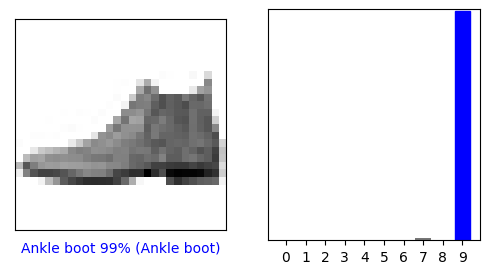

In [24]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

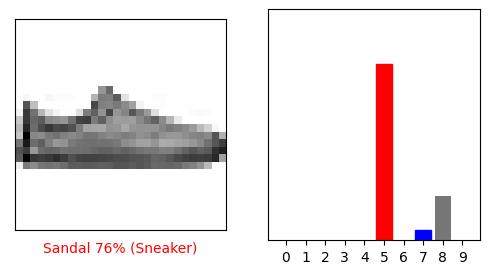

In [25]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

Let's plot several images with their predictions. Note that the model can be wrong even when very confident.

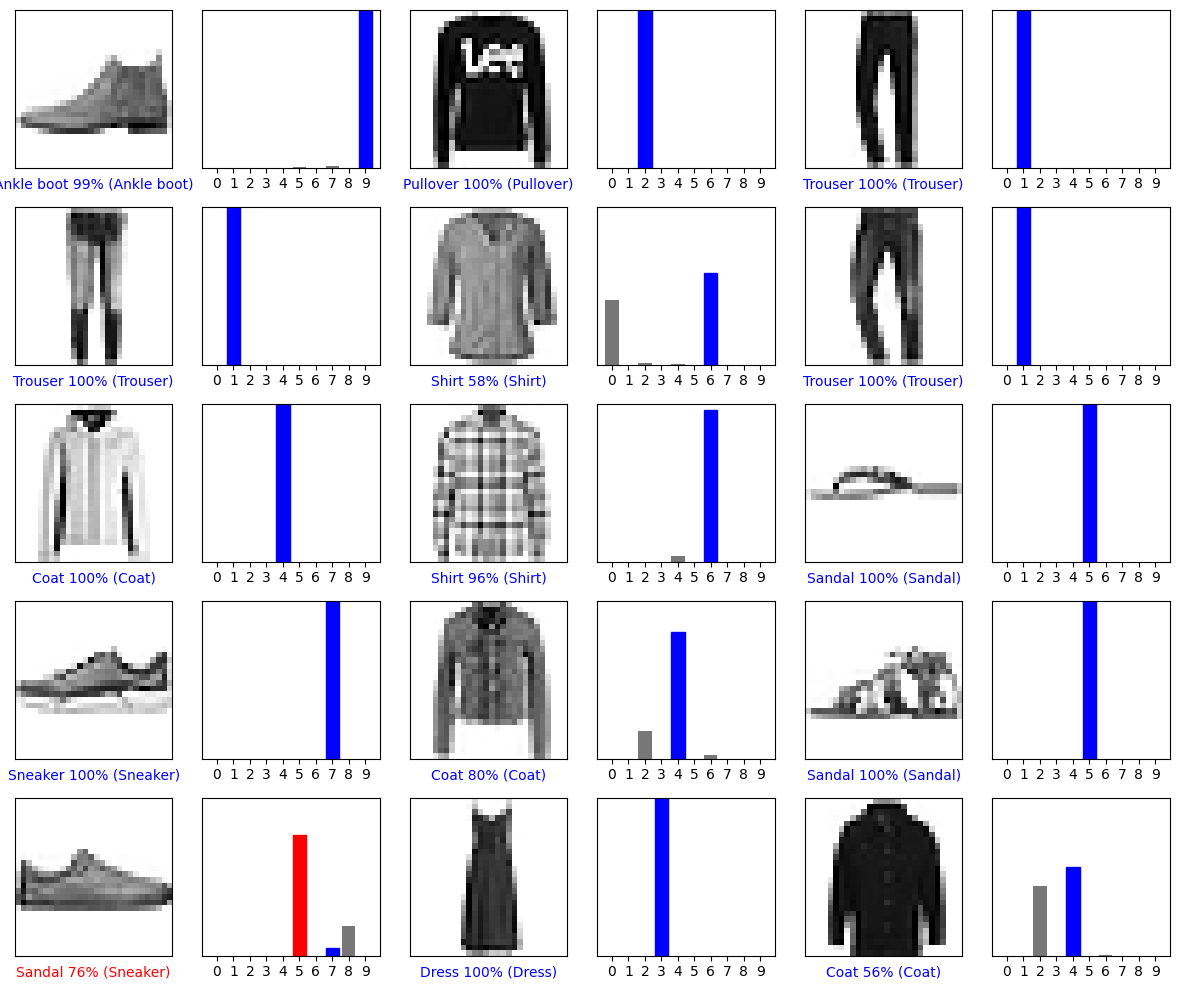

In [26]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

## Use the trained model

Finally, use the trained model to make a prediction about a single image.

In [27]:
# Grab an image from the test dataset.
img = test_images[1]

print(img.shape)

(28, 28)


`tf.keras` models are optimized to make predictions on a *batch*, or collection, of examples at once. Accordingly, even though you're using a single image, you need to add it to a list:

In [28]:
# Add the image to a batch where it's the only member.
img = (np.expand_dims(img,0))

print(img.shape)

(1, 28, 28)


Now predict the correct label for this image:

In [29]:
predictions_single = probability_model.predict(img)

print(predictions_single)


1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step


[[9.8218006e-06 1.6241313e-12 9.9978024e-01 2.5675090e-10 1.4467262e-04
  5.7958114e-14 6.5363645e-05 5.1339265e-20 3.2502893e-13 2.1984588e-13]]


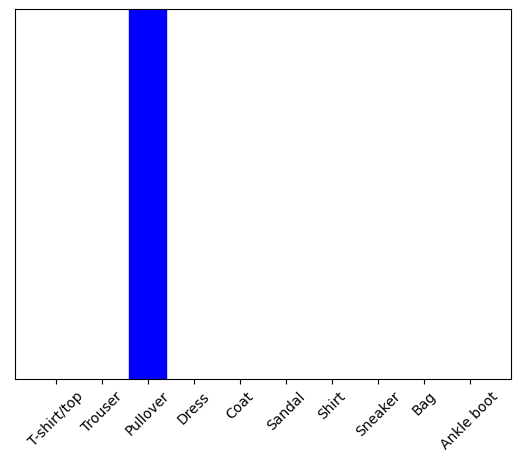

In [30]:
plot_value_array(1, predictions_single[0], test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)
plt.show()

`tf.keras.Model.predict` returns a list of lists—one list for each image in the batch of data. Grab the predictions for our (only) image in the batch:

In [31]:
np.argmax(predictions_single[0])

2

And the model predicts a label as expected.